# Clustering

In this notebook we will be going over how to use clustering in machine learning. Specifically we will be focusing on K-Means clustering through SciKit-Learn and Principle Component Analysis (PCA) for visualizing data in high dimensions. Clustering is a technique that 'clusters' data points that are similar to each other. This is often used for pattern recognition, data visualization, and outlier detection. This is a very useful technique to know for machine learning and data science as most datasets are often too high of a dimensionality for humans to easily visualize. 

#### Video

https://www.youtube.com/watch?v=7JRb8G29g-Y&list=PLL0SWcFqypCl4lrzk1dMWwTUrzQZFt7y0&index=23 (Clustering)

# K-Means Clustering

K-Means is a particularily popular clustering choice due to its simplicity and efficiency. It organizes the data points into clusters by minimizing the variance within each cluster. This often leads to easy identification of distinct groupings within a dataset. K-Means is a great choice when dealing with low dimensional numerical datasets containing low noise, well separated clusters.

To start off we will import libraries and create some synthetic code to work with. The make_blobs generates some clustered data.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X, _ = make_blobs(n_samples=300, centers=4, n_features=2, cluster_std=1.0, random_state=42)

Next we will standaradize our data. This makes the clustering significantly better as it causes all the data points to be on the same numerical scale. 

In [3]:
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Next we will apply kmeans clustering. When running kmeans clustering it's important to specify the number of clusters that you want the KMeans model to sort the data into. This is something that is important to get right as it can improve how well the clustering can be interpreted.

After we've found a good number of clusters we can use kmeans to group the data and plot it.

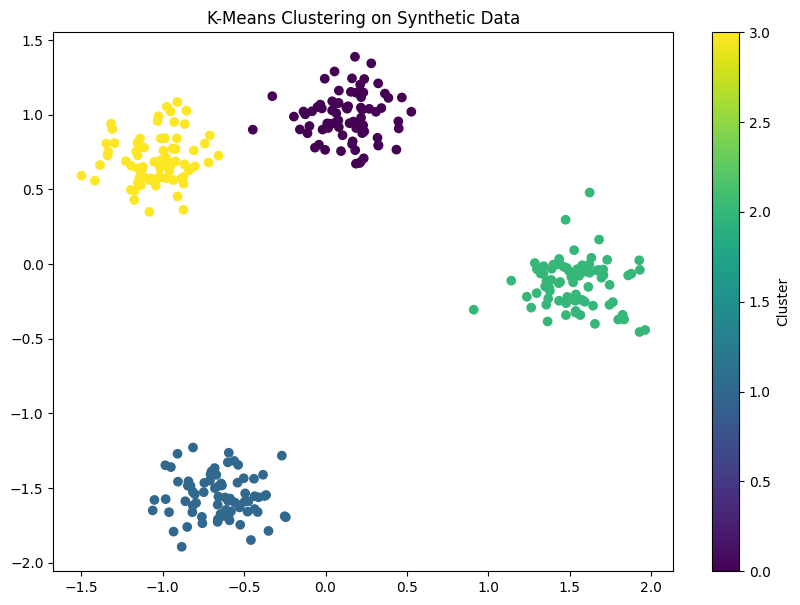

In [4]:

# Apply K-Means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
y_kmeans = kmeans.fit_predict(X_scaled)

# Plot the clusters in the 2D PCA space
plt.figure(figsize=(10, 7))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y_kmeans, cmap='viridis')
plt.title('K-Means Clustering on Synthetic Data')
plt.colorbar(label='Cluster')
plt.show()

We visually can see here that the silhouette score did a good job at finding the number of clusters that we should aim for. However, when dealing with higher dimensionality data this may not be as accurate. 

# Principal Component Analysis (PCA)

PCA reduces the dimensionality of the data while preserving as much variance as possible. This helps provide meaningful visualization and analysis of the clustered results. K-Means and PCA can be used together to cluster high dimensionality data. PCA is something to keep in mind if you need to visualize high dimensional data, it's very helpful. 

We will use the PCA tool from scikit-learn. When we generate the samples this time we will set the n_features to 10. This means that the data we are generating has 10 dimensions rather than the 2 from before. Furthermore, we will give the data 5 clustering centers. The next steps for kmeans clustering are the same from above. 

In [5]:
from sklearn.decomposition import PCA

# Generate synthetic 10-dimensional dataset
X, _ = make_blobs(n_samples=300, centers=5, n_features=10, cluster_std=1.0, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
y_kmeans = kmeans.fit_predict(X_scaled)



Now we will use PCA to reduce the dimensionality of the data. The n_components parameter controls how low we want to reduce the dimensions. First you define the PCA then you can apply the transformation to the **scaled** data. 

In [6]:
# Perform PCA to reduce the data to 2 dimensions for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)  # Apply the PCA transformation here

When we plot the clusters with PCA it's important to remember that you lose specificity of the axis.

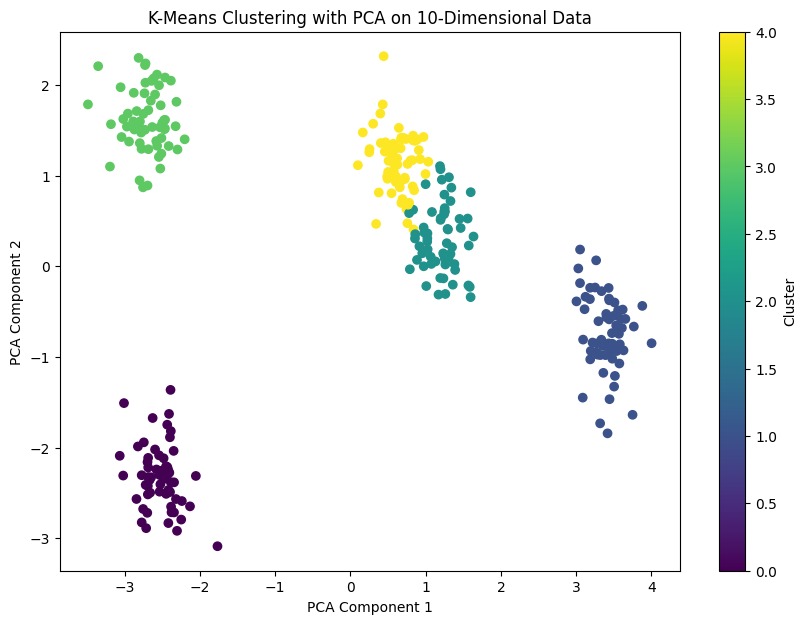

In [7]:
# Plot the clusters in the 2D PCA space
plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_kmeans, cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('K-Means Clustering with PCA on 10-Dimensional Data')
plt.colorbar(label='Cluster')
plt.show()

# Classification

One way that clustering can be used is to classify materials based on their properties. This is done by clustering them with similar materials and using the associated labels to figure out what they are. 

First we will import the required libraries for the kmeans predictions. Make sure to load your API key to collect the metals and insulators data from MPRester. 

In [25]:
#first some libraries
import pandas as pd
from pymatgen.ext.matproj import MPRester
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


Load your API key. This tutorial is using the legacy API so make sure to use the old API key.

In [ ]:
API_Key = ""

mpr = MPRester(API_Key)

Next lets load the metals and insulators data. We will use MPRester for this. We will put the data into a unified dataframe to predict with.

In [14]:
# Updated properties list to include conductivity (assuming it's available in the database)
props = ['pretty_formula', 'band_gap', 'density', 'formation_energy_per_atom', 'volume']

# Criteria for stable insulators: e_above_hull <= 0.02, band_gap > 0
criteria_insulators = {'e_above_hull': {'$lte': 0.02}, 'band_gap': {'$gt': 0}}
entries_insulators = mpr.query(criteria=criteria_insulators, properties=props)

# Create a DataFrame for the found insulators
df_insulators = pd.DataFrame(entries_insulators)
df_insulators['category'] = 'Insulator'  # Label insulators

# Criteria for stable metals: e_above_hull <= 0.02, band_gap = 0
criteria_metals = {'e_above_hull': {'$lte': 0.02}, 'band_gap': {'$eq': 0}}
entries_metals = mpr.query(criteria=criteria_metals, properties=props)

# Create a DataFrame for the found metals
df_metals = pd.DataFrame(entries_metals)
df_metals['category'] = 'Metal'  # Label metals

df_combined = pd.concat([df_insulators, df_metals], ignore_index=True)

# First, we need to drop non-numeric columns like 'pretty_formula'
df_clustering = df_combined.drop(columns=['pretty_formula', 'category'])

# Check the combined dataset
df_clustering.describe()

100%|██████████| 23935/23935 [00:12<00:00, 1987.88it/s]


Before we use it to predict labels, it is a good idea to train the model then check the clusters that it produces. Because this is high dimensional data we will use PCA to embed the clusters into lower dimensions. Standardizing the data is always a good idea as it makes sure that everything is on the same magnitude and can provide stability to models. We are using a KMeans model to cluster all of the data.

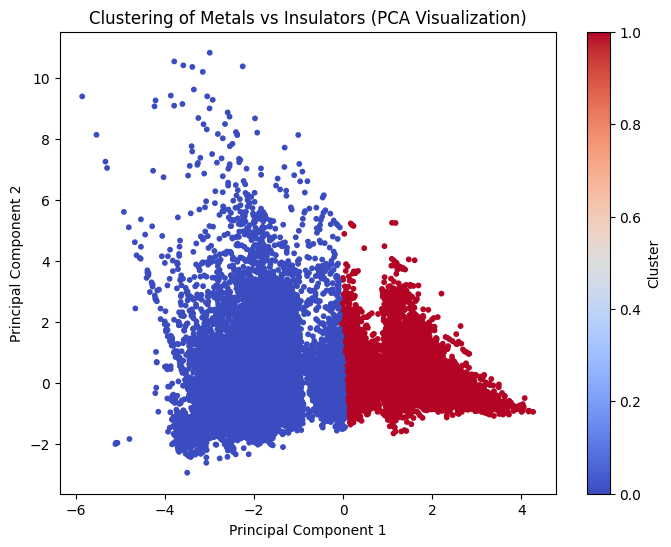

In [26]:

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_clustering)

# Apply K-means clustering using all dimensions
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(scaled_data)

# Add the cluster labels to the combined dataframe
df_combined['Cluster'] = kmeans.labels_

# Apply PCA for dimensionality reduction (reduce to 2 components for visualization)
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

# Visualize the PCA results
plt.figure(figsize=(8, 6))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=df_combined['Cluster'], cmap='coolwarm', s=10)
plt.title('Clustering of Metals vs Insulators (PCA Visualization)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

After visualization we will now train a model to predict labels. We will randomly separate 10 samples out of the data set then split the remaining data into train test splits. This is useful for predicting the accuracy of the model. After splitting the data, we train the model using the kmeans.fit function. After prediction, we predict the labels for the 10 unknown materials using the clusters. 

In [24]:
# First, separate 10 random samples from the dataset for prediction
df_sample = df_combined.sample(10, random_state=42)  # Separate 10 materials
df_remaining = df_combined.drop(df_sample.index)     # Remaining data for train-test split

# Standardize the remaining data
scaler = StandardScaler()
scaled_remaining = scaler.fit_transform(df_remaining.drop(columns=['pretty_formula', 'category', 'Label']))

# Perform train-test split on the remaining data
X_train, X_test, y_train, y_test = train_test_split(scaled_remaining, df_remaining['Label'], test_size=0.3, random_state=42)

# Fit the K-means model on the training data
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_train)

# Standardize the 10 separate materials
scaled_sample = scaler.transform(df_sample.drop(columns=['pretty_formula', 'category', 'Label']))

# Predict clusters for the 10 materials
sample_predictions = kmeans.predict(scaled_sample)

# Map the clusters to 'Insulator' or 'Metal'
# Adjust cluster labels if necessary
df_sample['Predicted_Cluster'] = sample_predictions
df_sample['Predicted_Label'] = df_sample['Predicted_Cluster'].apply(lambda x: 'Insulator' if x == 1 else 'Metal')

# Perform the KMeans prediction on the test set
y_pred = kmeans.predict(X_test)

# Now calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of K-means clustering: {accuracy:.2f}")

# Map the clusters to 'Insulator' or 'Metal'
df_sample['Predicted_Cluster'] = sample_predictions
df_sample['Predicted_Label'] = df_sample['Predicted_Cluster'].apply(lambda x: 'Insulator' if x == 1 else 'Metal')

# Map the true label from 'Label' column to 'True_Label'
df_sample['True_Label'] = df_sample['Label'].apply(lambda x: 'Insulator' if x == 1 else 'Metal')

# Print the predictions for the 10 separated materials
print("Predicted labels for the 10 materials:")
print(df_sample[['pretty_formula', 'band_gap', 'density', 'volume', 'Predicted_Label', 'True_Label']])

Accuracy of K-means clustering: 0.86
Predicted labels for the 10 materials:
      pretty_formula  band_gap    density       volume Predicted_Label  \
31157        EuGe2Ir    0.0000   9.612201   169.111964           Metal   
29688        SrNiSn2    0.0000   6.318378   201.698697           Metal   
44073        DyAl4Ni    0.0000   5.282150   206.929313           Metal   
42702        Hf2MoRh    0.0000  13.096147    70.476452           Metal   
35411          Y8Te3    0.0000   5.504083  1320.261768           Metal   
21790    RbIn(MoO4)2    3.7315   4.063945   850.156758       Insulator   
17819            ZnS    2.0266   3.995572   729.174409       Insulator   
11459   KSmH4(N2O7)2    3.3023   2.557451  1229.785832       Insulator   
44712        Yb2AgIr    0.0000  12.829599    83.633365           Metal   
30689        PaGaTc2    0.0000  11.864396    69.526299           Metal   

      True_Label  
31157      Metal  
29688      Metal  
44073      Metal  
42702      Metal  
35411      Met

As we can see here the KMeans model was able to achieve an accuracy of 87% across the test data. This is pretty good! Increasing the data we use to cluster the materials may increase the percentage. The model did a good job at predicting the true labels of the materials.